## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
X.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

Ответ: Пропущенных значений нет, категориальных признаков тоже.

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(52) # да здравствует Санкт-Петербург..

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

Ответ: stratify позволяет сохранить баланс классов в обучающей и тестовой выборках, что делает оценку модели более надежной и обеспечивает более точные результаты на новых данных. Особенно важно при категориальной целевой переменной и других категориальных признаках.

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
import warnings
warnings.filterwarnings("ignore")


new_X_train = X_train[['alcohol','magnesium']]
new_X_test = X_test[['alcohol','magnesium']]

scaler = StandardScaler()
scaler.fit(new_X_train)
X_train_scaled = scaler.transform(new_X_train)
X_test_scaled = scaler.transform(new_X_test)

neighbors = [1,3,5,10,15,25]
trained_models = {}
clear_info = pd.DataFrame()
for i in neighbors:
  knn = KNeighborsClassifier(n_neighbors = i, metric='euclidean')
  knn.fit(X_train_scaled,y_train)
  test_predict = knn.predict(X_test_scaled)
  train_predict = knn.predict(X_train_scaled)
  trained_models[i] = knn
  clear_info = clear_info.append({'NN': i,
                                    'Train': accuracy_score(y_train, train_predict),
                                    'Test': accuracy_score(y_test, test_predict)}, ignore_index=True)
clear_info = clear_info.round(2)
clear_info['NN'] = clear_info['NN'].astype(int)
print(clear_info.to_string(index=False))

 NN  Train  Test
  1   1.00  0.56
  3   0.80  0.63
  5   0.78  0.63
 10   0.75  0.65
 15   0.72  0.63
 25   0.69  0.69


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [ ]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

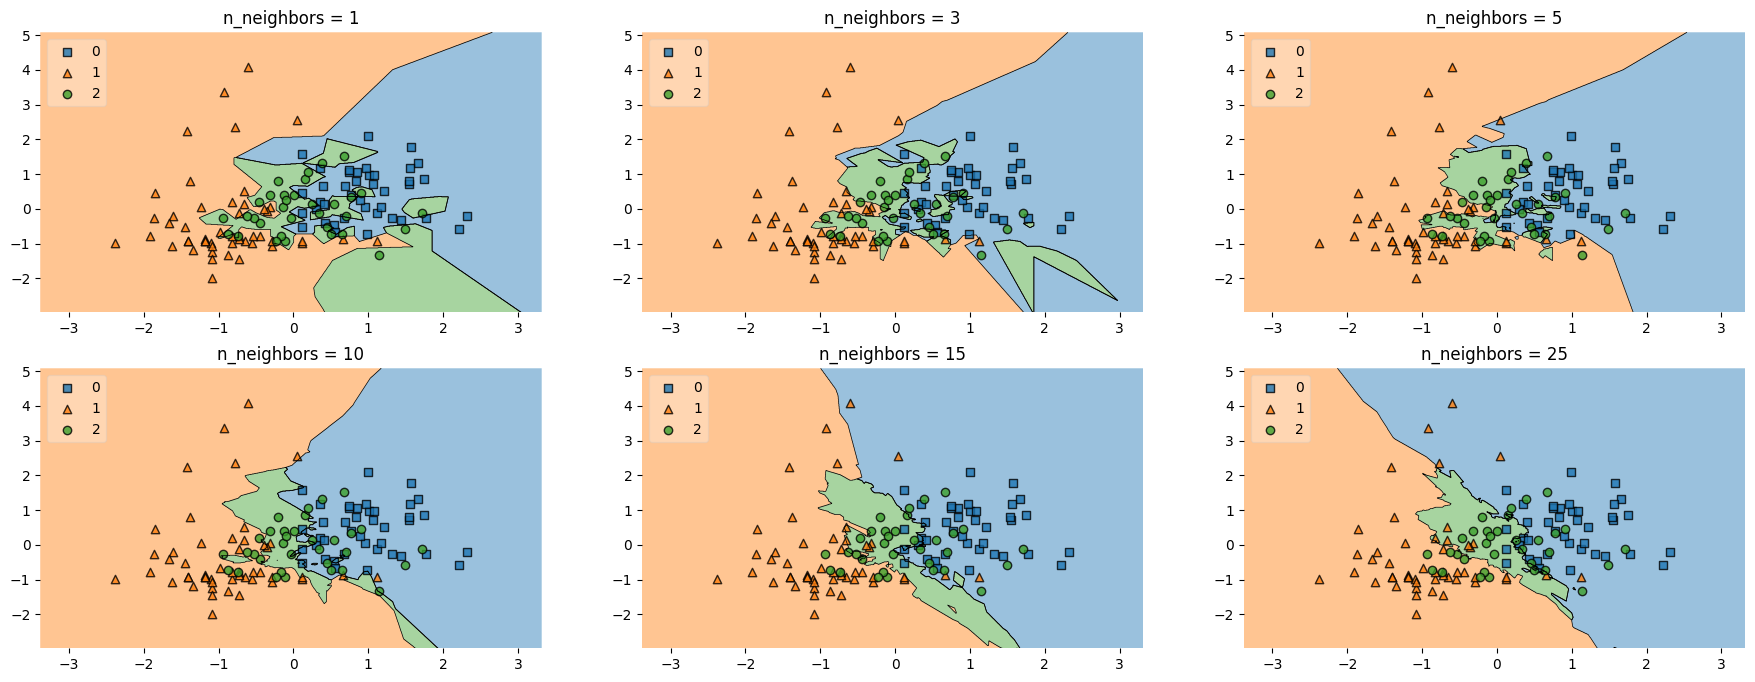

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(18,8))

neighbors = [1,3,5,10,15,25]
models = trained_models.items()

for (lab, clf), grd in zip(models, itertools.product([0, 1, 2], repeat=2)):
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_decision_regions(X=X_train_scaled, y=y_train, clf=clf, legend=2)
    plt.title(f'n_neighbors = {lab}')
plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Ответ: Из 1.3 можно сказать, что лучше всего использовать 25 соседей, так как accuracy на тестовой выборке самый большой, при этом он не отличается координально от трэйна. Также хороший результат показали 10 соседей.
Явное переобучение можно выделить в первых двух графиках(1,3 соседей), так, например, зеленая область разделена на маленькие островки, в которых содержатся зеленые объекты. При одном соседе accuracy трэйна равна 1, что явно говорит о том, что модель переобучилась. В общем-то говоря, геометрия у самого лучшего результата такая, что каждая зона - это цельная область, не разделенная на маленькие островки.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

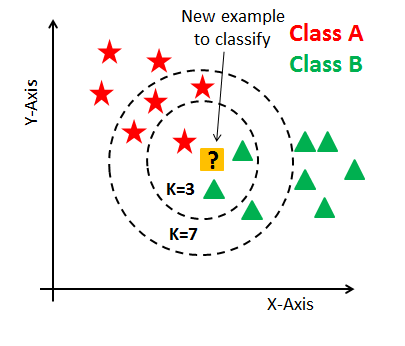

In [2]:
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import euclidean_distances

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
      # просто берем всю обучающую выборку в себя
      self.X_train = X
      self.y_train = y

    def predict(self, X):
      pred = []

      euclidean_dist = self.count_distance(X, self.X_train)

      # пробегаемся по всему вектору расстояний
      for dist in euclidean_dist:
        # берем индексы первых k соседей
        k_neighbors = np.argsort(dist)[:self.k]
        # находим самый частый класс
        pred.append(np.argmax(np.bincount(self.y_train[k_neighbors])))
      return np.array(pred)

    def count_distance(self, x, y):
      # какая-то супер сложная(крутая!) функция для подсчета евклидового расстояния
      return np.sqrt(np.sum((x[:, np.newaxis] - y) ** 2, axis=2))


In [3]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [4]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [6]:
data = pd.read_csv('data/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [7]:
data.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Ответ: пропусков нет

In [8]:
data = data.drop('Unnamed: 0', axis=1)


удалим столбец из индексов строк

In [9]:
data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [10]:
print(data.corr()['price'].drop('price'))
data.corr()

carat    0.921591
depth   -0.010647
table    0.127134
x        0.884435
y        0.865421
z        0.861249
Name: price, dtype: float64


<ipython-input-10-823870e1bf2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data.corr()['price'].drop('price'))
<ipython-input-10-823870e1bf2c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Ответ: с целевой переменной сильно коррелирует месса(carat) и размер(x,y,z) алмаза

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [11]:
data_hot = pd.get_dummies(data)
data_hot

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,0,1,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [384]:
from sklearn.model_selection import train_test_split
np.random.seed(52) # И этот город наш

bins = np.linspace(0, 19000, 500)
y_binned = np.digitize(y, bins)


X = data_hot.drop('price', axis=1)
y = data_hot['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y_binned)


Далем бинаризацию, чтобы можно было применить stratify

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [385]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# берем имена столбцов c вещественными признакми
X_real_train_names = X_train.select_dtypes(include=['float64']).columns
X_train_scaled = X_train.copy()
X_train_scaled[X_real_train_names] = scaler.fit_transform(X_train[X_real_train_names])


X_real_test_names = X_test.select_dtypes(include=['float64']).columns
X_test_scaled = X_test.copy()
X_test_scaled[X_real_train_names] = scaler.transform(X_test[X_real_test_names])


**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [388]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_scaled, y_train)

train_predictions = reg.predict(X_train_scaled)
test_predictions = reg.predict(X_test_scaled)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f'train: {train_mse}')
print(f'test: {test_mse}')

train: 1294584.8069458676
test: 1236281.2115773945


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [389]:
reg.coef_


array([ 5.26341293e+03, -8.80028788e+01, -5.22850370e+01, -1.04340367e+03,
        1.30985028e+00, -4.23862484e+01, -5.99017146e+02, -1.56802032e+01,
        2.69427680e+02,  1.86255739e+02,  1.59013930e+02,  8.33835602e+02,
        6.21872889e+02,  5.52018087e+02,  3.42030673e+02, -1.44751524e+02,
       -6.31777101e+02, -1.57322863e+03, -3.84705806e+03,  1.55371321e+03,
       -1.59614384e+02, -1.10774890e+03,  7.64386698e+02,  4.50105999e+02,
        1.19186993e+03,  1.15434552e+03])

Ответ: Среди вещественных выделяются карат и x

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [390]:
from sklearn.linear_model import Lasso, Ridge
reg_lasso = Lasso(alpha=10).fit(X_train_scaled, y_train)
reg_ridge = Ridge(alpha=10).fit(X_train_scaled, y_train)

print(reg_lasso.coef_)
print(reg_ridge.coef_)

[ 4787.73670897   -98.20798593   -72.01350719  -637.40138984
    -0.           -45.36880628  -456.15490568   -52.06859
    95.80646954     0.             0.           345.41425182
   174.95060736   114.27845724     0.          -425.24771054
  -846.63641055 -1674.88266453 -3587.88271364   703.32887871
  -640.76170366 -1528.85418222   156.35217679   -24.13662878
   512.92645168   530.09235109]
[ 5.22497471e+03 -8.66807915e+01 -5.26554484e+01 -1.00338610e+03
 -5.16025758e-01 -4.58958602e+01 -6.01129416e+02 -1.54521170e+01
  2.70245891e+02  1.86062371e+02  1.60273271e+02  8.28979728e+02
  6.18216093e+02  5.48417182e+02  3.40344837e+02 -1.45234958e+02
 -6.28724042e+02 -1.56199884e+03 -3.77339674e+03  1.53354287e+03
 -1.67699093e+02 -1.11150643e+03  7.54294178e+02  4.41471533e+02
  1.17977140e+03  1.14352228e+03]


Ответ: С lasso регрессией сильно уменьшились веса, появились даже нули. Проблема мультиколлинеарности проявлялась довольно сильно в изначальной регрессии. Это видно из того, что признаки имели большие значения коэффициентов, и некоторые из них были даже выше, чем 1000, что может свидетельствовать о наличии высокой корреляции между признаками.

Ridge тоже снизила веса и попаталась решить проблему мультиколлинеарности, это произошло путем снижения весов, этот вид регуляризации занижает веса, но не зануляет их.

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.472e+07, tolerance: 6.004e+07
  model = cd_fast.enet_coordinate_descent(


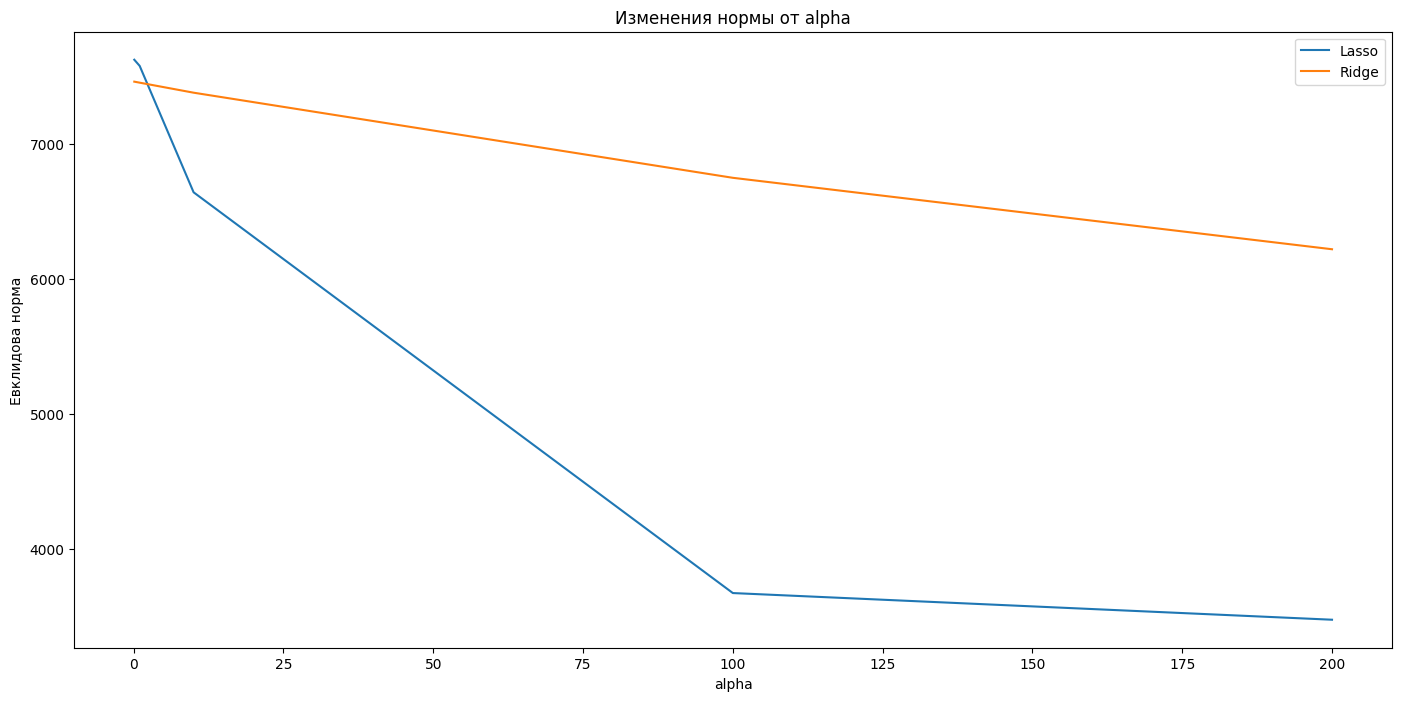

In [391]:
alphas = [0.1, 1, 10, 100, 200]
plt.figure(figsize=(17,8))

losses_l = []
losses_r = []
for alpha in alphas:
  reg_l = Lasso(alpha=alpha).fit(X_train_scaled, y_train)
  reg_r = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
  losses_l.append(np.linalg.norm(reg_l.coef_))
  losses_r.append(np.linalg.norm(reg_r.coef_))

plt.plot(alphas, losses_l, label='Lasso')
plt.plot(alphas, losses_r, label='Ridge')
plt.title(f'Изменения нормы от alpha')
plt.xlabel(f'alpha')
plt.ylabel('Евклидова норма')
plt.legend()
plt.show()



Ответ: Lasso регрессия более агрессивно уменьшает веса, это происходит из-за реализация регуляризации внутри класса, lasso регуляризация минимизирует сумму абсолютных значений весов коэффициентов, вследствие этого L1-регуляризация может занулять несущественные признаки, также lasso помогает избежать мультиколлениарности признаков. Ridge же считает сумму квадратов весов коэффициентов, однако это не приводит к занулению весов.

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [392]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5)
lasso_cv.fit(X_train_scaled, y_train)
avg_mes = lasso_cv.mse_path_.mean(axis=1)

best_alpha_index = np.argmin(avg_mes)

best_alpha = lasso_cv.alphas_[best_alpha_index]
best_alpha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2320795245.491768, tolerance: 48110040.92890865
  model = cd_fast.enet_coordinate_descent_gram(


1.0

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [394]:
final_reg = Lasso(alpha=best_alpha).fit(X_train_scaled, y_train)
print(final_reg.coef_)

[ 5215.83537479   -89.14276877   -54.10982998 -1001.40559054
    -0.           -42.85237527  -729.83592291  -164.44277088
   107.09627928    20.58626029     0.           477.52947859
   269.61254885   200.67087801     0.          -480.31594673
  -960.87846571 -1891.06270996 -4316.32609825   973.29414855
  -703.16971804 -1645.22971317   208.20717507   -92.67237851
   628.49554125   596.37085636]


Ответ: Информативные: карат, сильно влияет x, однако он с минусом, потому что пытается скомпенсировать карат из-за их мультиколлинеарности(чем больше вес, тем больше бриллиант и наоборот). В категориальном признаке color есть, например, цвет J с большим отрицательным весом, это происходит из-за непривлекательности цвета для покупателей. Среди clarity тоже есть такие случаи, так, например, I-1 это плохая прозрачность бриллианта, поэтому она с огромным минусом. Есть еще пару цветов и видов clarity, которые влияют

Среди неинформативных можно выделить те, которые занулились из-за мультиколлинеарности, также маленькие веса у cut.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [396]:
pred_lasso = final_reg.predict(X_test_scaled)
pred_cas = reg.predict(X_test_scaled)

lasso_mse = mean_squared_error(y_test, pred_lasso)
linear_mse = mean_squared_error(y_test, pred_cas)


print("Lasso", lasso_mse)
print("linear", linear_mse)

Lasso 1236624.1664743703
linear 1236281.2115773945


Нельзя выделить какую-то одну модель, обе дали примерно одинаковый результат на тесте, из плюсов лассо можно выделить, что она убрала мультиколлинеарность, занулив признаки. У обычной линейной могут быть проблемы с мультиколлинеарностью в других случаях.

МЕМА НЕ БУДЕТ, я не нашел хороший